In [16]:
import sys
import os
import yaml
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

sys.path.insert(0, '../')
#import utils.utils as utils
from pathlib import Path
from sklearn.model_selection import train_test_split


# TensorFlow imports
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers

from model.data_utils import DataGen, get_gen
from model.model import GMM_Survival
from model.losses import Losses
from model.eval_utils_1 import cindex_metric
from model.networks import VGGEncoder, VGGDecoder, Encoder, Decoder, Encoder_small, Decoder_small
from model.utils import weibull_scale, weibull_log_pdf, tensor_slice

# Survival Clustering
from sklearn.cluster import KMeans
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

%matplotlib inline

### VADESC

In [17]:
# Pretrain autoencoder
checkpoint_path = "autoencoder/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

tfd = tfp.distributions
tfkl = tf.keras.layers
tfpl = tfp.layers
tfk = tf.keras

{'data': {'data_name': 'test'}, 'training': {'eval_frequency': 200, 'inp_shape': 11684, 'latent_dim': 2, 'num_clusters': 2, 'activation': 'none', 'monte_carlo': 1, 'learn_prior': True, 'weibull_shape': 1, 'survival': True, 'sample_surv': False}}

In [18]:
def plot_bigroup_kaplan_meier(t, d, c_, dir=None, postfix=None, legend=False, legend_outside=False):
    labels = np.unique(c_)
    for l in labels:
        kmf = KaplanMeierFitter()
        kmf.fit(t[c_ == l], d[c_ == l], label="cluster " + str(int(l + 1)))
        kmf.plot(ci_show=True, alpha=0.75, color=CB_COLOR_CYCLE[int(l)], linewidth=2)

    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.xticks(np.arange(0, 10, 1), np.arange(0, 10000, 1000)) # x축 눈금 위치와 라벨 변경


In [19]:
def setup_seed(seed):
    random.seed(seed)  
    np.random.seed(seed) 
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  

In [20]:
# Fix random seed
seed = 20220229
setup_seed(seed)

In [22]:
project_dir = os.path.dirname(os.getcwd())
config_path = Path(os.path.join(project_dir, '../configs/test.yml'))
with config_path.open(mode='r') as yamlfile:
    configs = yaml.safe_load(yamlfile)
print(configs)

{'data': {'data_name': 'test'}, 'training': {'eval_frequency': 200, 'inp_shape': 11684, 'latent_dim': 2, 'num_clusters': 2, 'activation': 'none', 'monte_carlo': 1, 'learn_prior': True, 'weibull_shape': 1, 'survival': True, 'sample_surv': False}}


In [23]:
losses = Losses(configs)
rec_loss = losses.loss_reconstruction_mse

In [26]:
#load TCGA data
GeneCount = np.load('../../processedData/GeneCount.npy',allow_pickle=True)
TTE = np.load('../../processedData/TTE.npy',allow_pickle=True)
EVENT = np.load('../../processedData/Event.npy',allow_pickle=True)

X_train = GeneCount
Y_train = np.stack([TTE,EVENT],axis=1)

X_train,X_test,Y_train,Y_test=train_test_split(X_train,Y_train,test_size=0.2,shuffle=True,random_state=44)

In [27]:
# Fix seeds
setup_seed(seed)

In [28]:
# Construct the model & optimizer
model = GMM_Survival(**configs['training'])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer, loss={"output_1": rec_loss},
              metrics={"output_2": cindex_metric})

# Use survival times during training
tf.keras.backend.set_value(model.use_t, np.array([1.0]))

In [29]:
# Data generators
gen_train = get_gen(X_train, Y_train,configs, 16)
gen_test = get_gen(X_test, Y_test, configs, 16, validation=True)

### Training & Evaluation

In [30]:
# Fit the model
model.fit(gen_train,validation_data=gen_test, epochs=55, verbose=1)
model.summary()

Epoch 1/55
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.Transformed

In [32]:
model.save('../model_weights/weights.h5')

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

### Load Model

In [33]:
tf.keras.backend.set_value(model.use_t, np.array([0.0]))

model.sample_surv = False

rec, z_sample, p_z_c, p_c_z, risk_scores, lambdas = model.predict((X_train, Y_train), batch_size=16)

risk_scores = np.squeeze(risk_scores)

# Hard cluster assignments
c_hat = np.argmax(p_c_z, axis=-1)

In [34]:
CB_COLOR_CYCLE = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

### VADESC

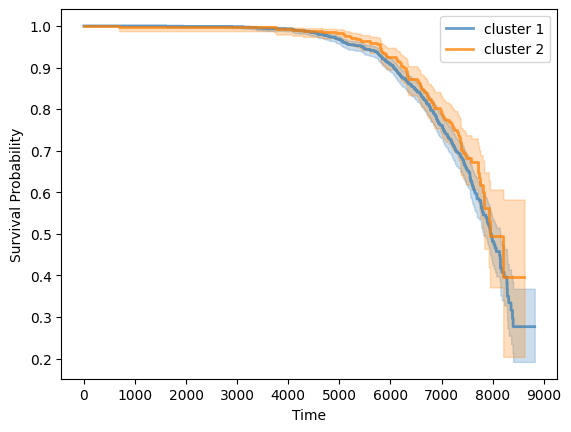

In [35]:
plot_bigroup_kaplan_meier(t=Y_train[:,0], d=Y_train[:,1],c_=c_hat ,legend=True, legend_outside=True)

### CoxPH

In [38]:
with open('../../processedData/TotalData1.pkl', 'rb') as f:
     Totaldata = pickle.load(f)

C:\Users\user\anaconda3\envs\ai\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\user\anaconda3\envs\ai\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\user\anaconda3\envs\ai\lib\site-packages\lifelines\utils\__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


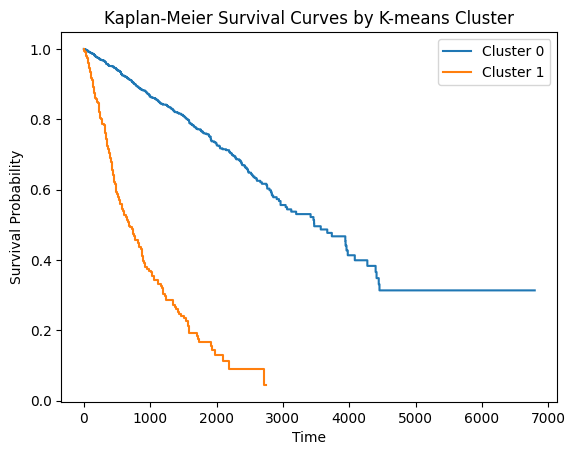

In [39]:
data = Totaldata.iloc[:, 2:]
cph = CoxPHFitter()
cph.fit(data, duration_col='time', event_col='event')

kmeans = KMeans(n_clusters=2)
kmeans.fit(cph.predict_survival_function(data).T)

np.unique(kmeans.labels_, return_counts=True)

cluster_labels = kmeans.labels_
kmf = KaplanMeierFitter()

plt.figure()

for cluster in np.unique(cluster_labels):
    idx = cluster_labels == cluster
    kmf.fit(data.loc[idx, 'time'], event_observed=data.loc[idx, 'event'], label=f'Cluster {cluster}')
    kmf.plot(ci_show=False)

plt.title('Kaplan-Meier Survival Curves by K-means Cluster')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()


In [40]:
Y_train = np.append(Y_train, np.reshape(c_hat, (Y_train.shape[0], 1)), axis=1)
cols = ['time','event','cluster']
coxdata = pd.DataFrame(Y_train,columns=cols)
dataset = coxdata

### K-MEANS

In [41]:
X_train.shape

(2353, 11684)

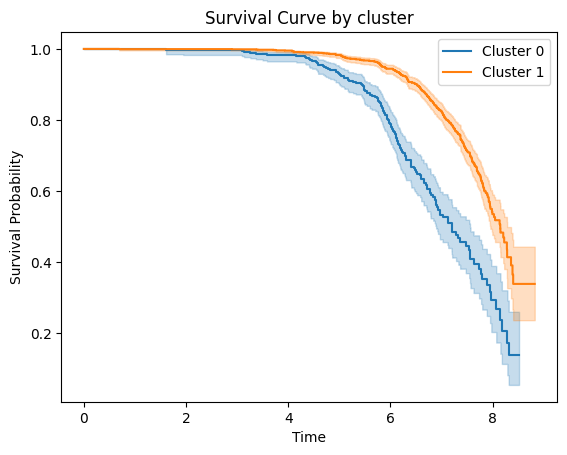

In [42]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train)

labels = kmeans.labels_
survival_curves = []

for label in np.unique(labels):
    cluster_indices = np.where(labels == label)

    tte = Y_train[:,0]
    event = Y_train[:,1]
    kmf = KaplanMeierFitter()
    kmf.fit(tte[cluster_indices], event[cluster_indices], label=f"Cluster {label}")
    survival_curves.append(kmf)

for kmf in survival_curves:
    kmf.plot()
    
plt.title("Survival Curve by cluster")
plt.xlabel("Time")
plt.ylabel("Survival Probability")

plt.show()